In [1]:
# Mitigating Noise on Real QC
# Measurement Error Mitigation
from qiskit import *

In [2]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2],[0,1,2])

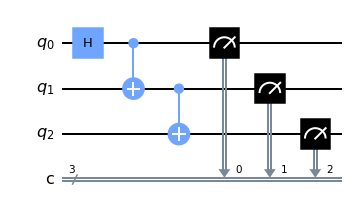

In [3]:
%matplotlib inline
circuit.draw(output='mpl')

In [4]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend = simulator, shots = 1024).result()

In [5]:
from qiskit.tools.visualization import plot_histogram

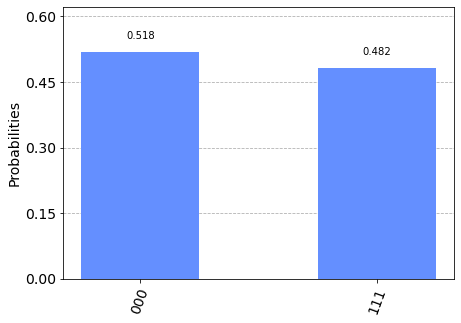

In [6]:
plot_histogram(sim_result.get_counts(circuit))

In [7]:
# running the simulation on a real QC
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_belem')

In [9]:
job = execute(circuit, backend = device, shots = 1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

6042a4f39601fe0105ba271e
Job Status: job has successfully run


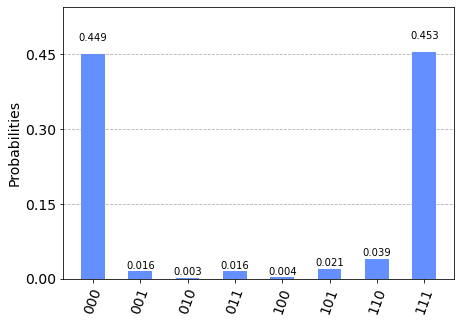

In [10]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [11]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [13]:
cal_circuits, state_labeles = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

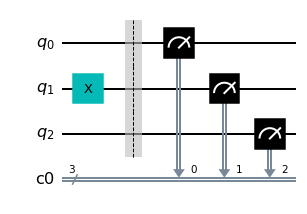

In [14]:
cal_circuits[2].draw(output='mpl')

In [15]:
len(cal_circuits)

8

In [16]:
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

60435a71cbf21156b9723f58
Job Status: job has successfully run


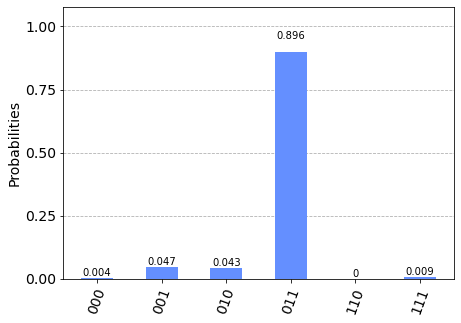

In [17]:
plot_histogram(
cal_results.get_counts(cal_circuits[3]))

In [19]:
mess_fitter = CompleteMeasFitter(cal_results, state_labeles)

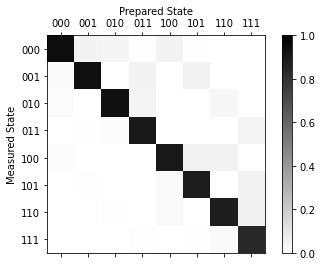

In [20]:
mess_fitter.plot_calibration()

In [21]:
meas_filter = mess_fitter.filter

In [22]:
mitigated_result = meas_filter.apply(device_result)

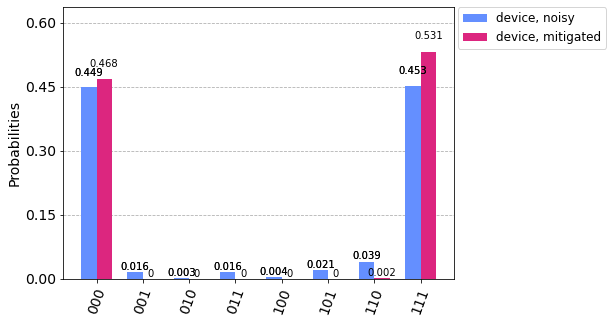

In [23]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

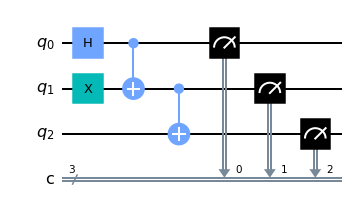

In [24]:
circuit2 = QuantumCircuit(3, 3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2], [0,1,2])
circuit2.draw(output='mpl')

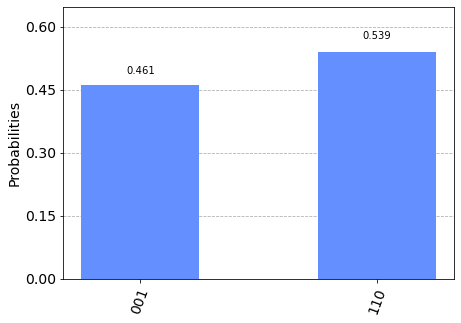

In [25]:
plot_histogram(

    execute(circuit2, backend=simulator, shots = 1024).result().get_counts(circuit2)
    
)

In [28]:
# running on a real QC device
provider2 = IBMQ.get_provider(hub='ibm-q')
device2 = provider2.get_backend('ibmq_5_yorktown')

In [29]:
device_counts_2 = execute(circuit2, backend=device2, shots=1024).result().get_counts(circuit2)

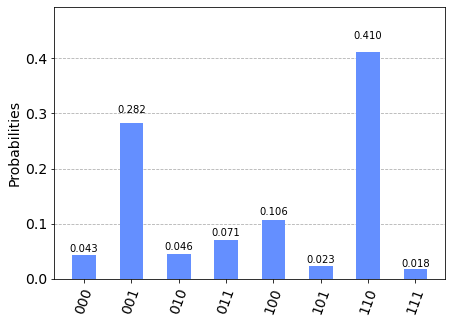

In [30]:
plot_histogram(device_counts_2)

In [31]:
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)

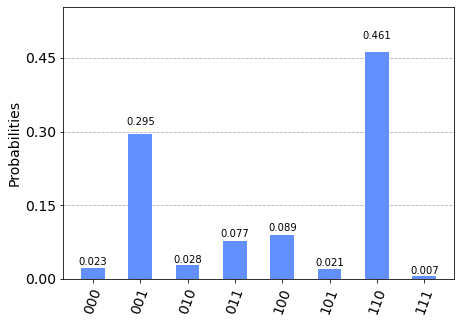

In [32]:
plot_histogram(device_mitigated_counts_2)

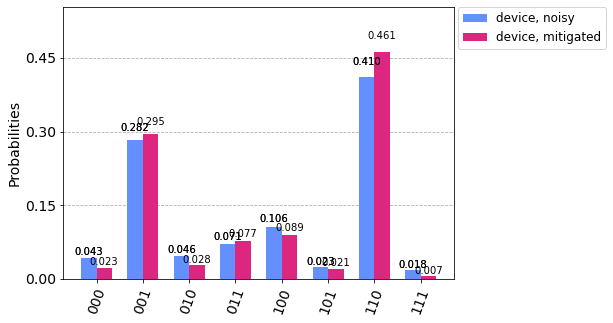

In [34]:
plot_histogram([device_counts_2, device_mitigated_counts_2], legend=['device, noisy', 'device, mitigated'])